## Data Exploration

ET and EEG feature comparison between Normal Reading (NR) and Task Specific Reading (TSR) / Annotation Reading (AR) for [ZuCo](https://osf.io/q3zws/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import gzip
import math
import matplotlib
import os
import random
import re
import scipy

from scipy.stats import pearsonr, ttest_rel
from plot_funcs import *
from utils import *

In [2]:
# instantiate data transformer object for task 1, 2, or 3 on sentence level (no scaling for now)
datatransform_t1 = DataTransformer('task1', level='sentence', scaling='raw', fillna='zeros')
datatransform_t2 = DataTransformer('task2', level='sentence', scaling='raw', fillna='zeros')
datatransform_t3 = DataTransformer('task3', level='sentence', scaling='raw', fillna='zeros')

In [3]:
# get data for all subjects according to settings specified in cell above
# NOTE: data for each sbj will be stored in pd.DataFrame
sbjs_t1 = [datatransform_t1(i) for i in range(12)]
sbjs_t2 = [datatransform_t2(i) for i in range(12)]
sbjs_t3 = [datatransform_t3(i) for i in range(12)]

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Lukas\Documents\GitHub\NER-with-EEG-and-ET\utils.py:175: RuntimeWarning: invalid value encountered in true_divide
  features[idx, 3:-1] /= n_words_fixated


In [5]:
# for each dataset check whether data is complete and transformation was performed correctly
for i, (sbj_t1, sbj_t2, sbj_t3) in enumerate(zip(sbjs_t1, sbjs_t2, sbjs_t3)):
    print("Subject:", i+1)
    print()
    print("Number of sents for task 1: ", len(sbj_t1))
    print("Number of sents for task 2: ", len(sbj_t2))
    print("Number of sents for task 3: ", len(sbj_t3))
    print()

Subject: 1

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 2

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 3

Number of sents for task 1:  299
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 4

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  360

Subject: 5

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 6

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 7

Number of sents for task 1:  400
Number of sents for task 2:  250
Number of sents for task 3:  407

Subject: 8

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  359

Subject: 9

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3

### Eye-Tracking feature comparison between first and second half of Task 1 (NR)

First and second half of Task 1 (NR Sentiment) have to be compared to inspect whether an order effect has to be reported

In [6]:
# split data into first and second half
first_half, second_half = split_data(sbjs_t1)

In [7]:
# check whether data splitting was performed correctly
#for i, (first, second) in enumerate(zip(first_half, second_half)):
#    print("Subject:", i)
#    print()
#    print("Number of sents in first half:", len(first))
#    print("Number of sents in second half:", len(second))
#    print()

In [16]:
sentlen_m1, wordlen_m1, omissions_m1, fixations_m1, pupilsize_m1, gd_m1, trt_m1, ffd_m1, gpt_m1, bncfreq_m1 = compute_means(first_half)
sentlen_m2, wordlen_m2, omissions_m2, fixations_m2, pupilsize_m2, gd_m2, trt_m2, ffd_m2, gpt_m2, bncfreq_m2 = compute_means(second_half)

In [17]:
sentlens1, wordlens1, omissions1, fixations1, pupilsize1, gd1, trt1, ffd1, gpt1, bnc_freqs1 = compute_allvals(first_half)
sentlens2, wordlens2, omissions2, fixations2, pupilsize2, gd2, trt2, ffd2, gpt2, bnc_freqs2 = compute_allvals(second_half)

In [22]:
corr_mat(compute_allvals(sbjs_t1), heatmap=False)

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,GD,TRT,FFD,GPT,BNCFreq
SentLen,1.000000,-0.207487,0.176827,-0.249376,-0.042790,-0.210575,-0.316053,-0.155814,-0.282738,0.270083
MeanWordLen,-0.207487,1.000000,-0.270190,0.237504,-0.012421,0.292752,0.257303,0.108762,0.172753,-0.638324
omissionRate,0.176827,-0.270190,1.000000,-0.174083,0.027624,-0.099252,-0.202164,-0.180843,-0.181258,0.247578
nFixations,-0.249376,0.237504,-0.174083,1.000000,-0.036620,0.389100,0.923867,0.075564,0.843443,-0.240436
meanPupilSize,-0.042790,-0.012421,0.027624,-0.036620,1.000000,-0.014922,-0.046394,-0.014921,-0.039271,-0.007651
GD,-0.210575,0.292752,-0.099252,0.389100,-0.014922,1.000000,0.565322,0.621009,0.421198,-0.279252
TRT,-0.316053,0.257303,-0.202164,0.923867,-0.046394,0.565322,1.000000,0.353175,0.889270,-0.262502
FFD,-0.155814,0.108762,-0.180843,0.075564,-0.014921,0.621009,0.353175,1.000000,0.283641,-0.110249
GPT,-0.282738,0.172753,-0.181258,0.843443,-0.039271,0.421198,0.889270,0.283641,1.000000,-0.189415
BNCFreq,0.270083,-0.638324,0.247578,-0.240436,-0.007651,-0.279252,-0.262502,-0.110249,-0.189415,1.000000


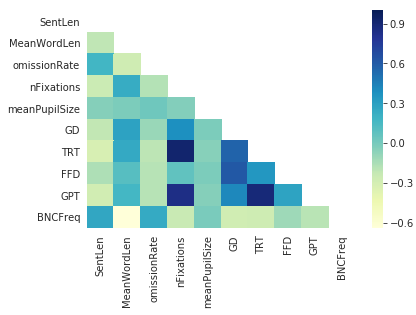

In [23]:
corr_mat(compute_allvals(sbjs_t1), heatmap=True, mask=True)

#### Mean fixations per word per subject

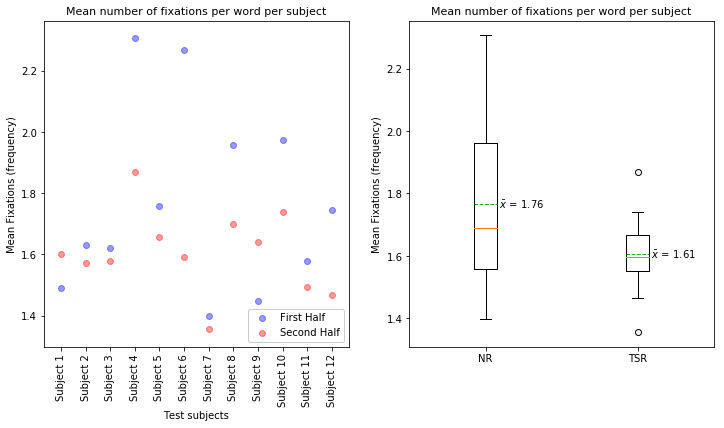

In [24]:
plot_fix(fixations_m1, fixations_m2)
#print("p-value:", randomsample_paired_ttest(fixations1, fixations2))

#### Omission rate on sentence level

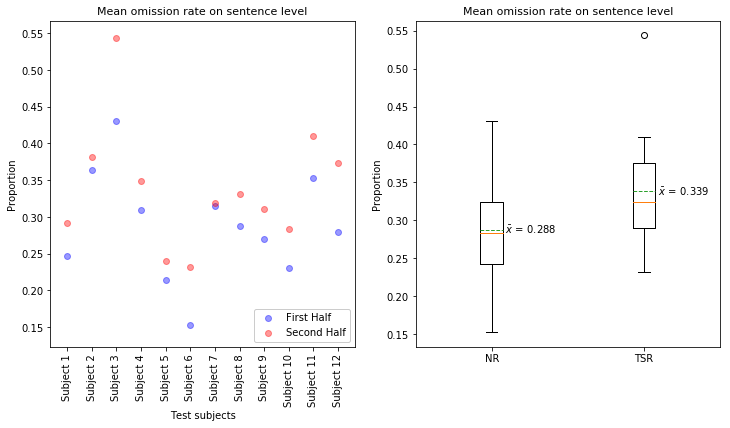

In [25]:
plot_omissions(omissions_m1, omissions_m2)

#### Mean GD per word per subject

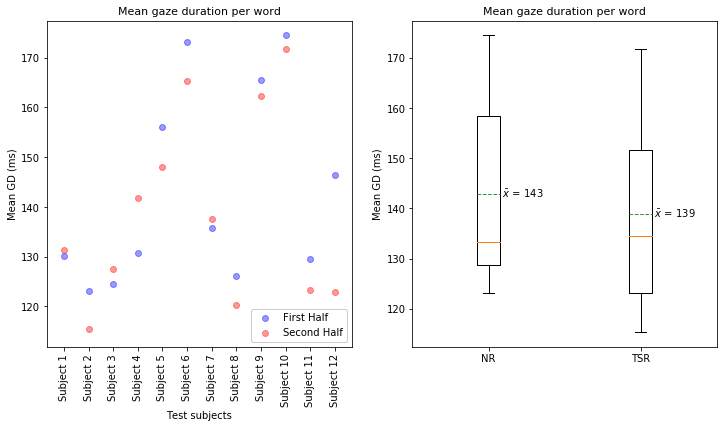

In [26]:
plot_gd(gd_m1, gd_m2)
#print("p-value:", randomsample_paired_ttest(gd1, gd2))

#### Mean TRT per word per subject

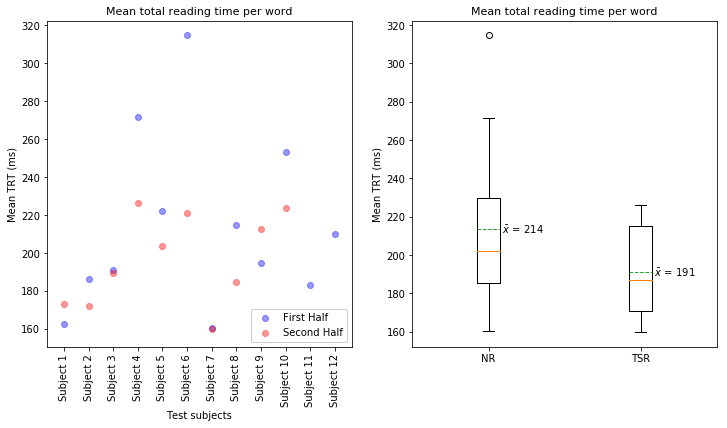

In [27]:
plot_trt(trt_m1, trt_m2)
#print("p-value:", randomsample_paired_ttest(trt1, trt2))

#### Mean FFD per word per subject

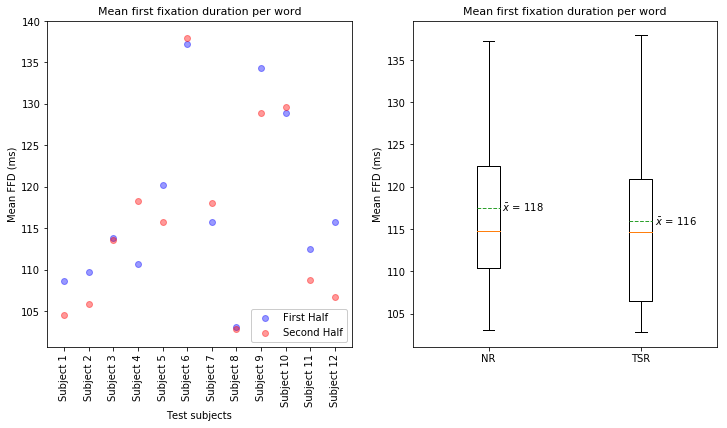

In [28]:
plot_ffd(ffd_m1, ffd_m2)
#print("p-value:", randomsample_paired_ttest(ffd1, ffd2))

### Eye-Tracking feature comparison between Task 2 (NR) and Task 3 (TSR)

In [29]:
sentlen_m_t2, wordlen_m_t2, omissions_m_t2, fixations_m_t2, pupilsize_m_t2, gd_m_t2, trt_m_t2, ffd_m_t2, gpt_m_t2, bncfreq_m_t2 = compute_means(sbjs_t2)
sentlen_m_t3, wordlen_m_t3, omissions_m_t3, fixations_m_t3, pupilsize_m_t3, gd_m_t3, trt_m_t3, ffd_m_t3, gpt_m_t3, bncfreq_m_t3 = compute_means(sbjs_t3)

In [30]:
sentlens_t2, wordlens_t2, omissions_t2, fixations_t2, pupilsize_t2, gd_t2, trt_t2, ffd_t2, gpt_t2, bnc_freqs_t2 = compute_allvals(sbjs_t2)
sentlens_t3, wordlens_t3, omissions_t3, fixations_t3, pupilsize_t3, gd_t3, trt_t3, ffd_t3, gpt_t3, bnc_freqs_t3 = compute_allvals(sbjs_t3)

In [31]:
corr_mat(compute_allvals(sbjs_t2))

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,GD,TRT,FFD,GPT,BNCFreq
SentLen,1.000000,0.092248,0.040784,-0.102107,-0.041531,-0.077621,-0.149289,-0.059944,-0.135942,0.085329
MeanWordLen,0.092248,1.000000,-0.140128,0.089848,-0.023629,0.107874,0.066725,-0.010725,0.026757,-0.090237
omissionRate,0.040784,-0.140128,1.000000,-0.294206,0.002062,-0.255537,-0.337702,-0.300276,-0.293148,0.098750
nFixations,-0.102107,0.089848,-0.294206,1.000000,0.019607,0.434918,0.928690,0.198415,0.830028,-0.141851
meanPupilSize,-0.041531,-0.023629,0.002062,0.019607,1.000000,0.085075,0.048578,0.139681,0.009082,0.022109
GD,-0.077621,0.107874,-0.255537,0.434918,0.085075,1.000000,0.618623,0.694371,0.481751,-0.079906
TRT,-0.149289,0.066725,-0.337702,0.928690,0.048578,0.618623,1.000000,0.450090,0.881029,-0.143088
FFD,-0.059944,-0.010725,-0.300276,0.198415,0.139681,0.694371,0.450090,1.000000,0.385659,-0.024958
GPT,-0.135942,0.026757,-0.293148,0.830028,0.009082,0.481751,0.881029,0.385659,1.000000,-0.140980
BNCFreq,0.085329,-0.090237,0.098750,-0.141851,0.022109,-0.079906,-0.143088,-0.024958,-0.140980,1.000000


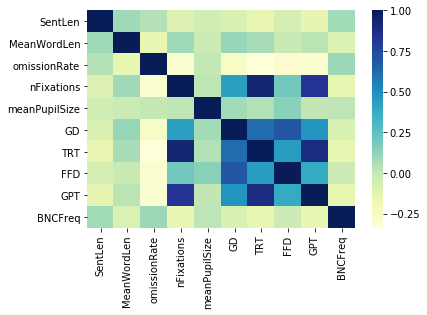

In [37]:
corr_mat(compute_allvals(sbjs_t2), heatmap=True, mask=False)

In [34]:
corr_mat(compute_allvals(sbjs_t3))

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,GD,TRT,FFD,GPT,BNCFreq
SentLen,1.000000,0.027612,0.213212,-0.081536,-0.046910,-0.080330,-0.133258,-0.122483,-0.111039,-0.137217
MeanWordLen,0.027612,1.000000,-0.144142,0.126453,-0.008896,0.084175,0.090698,0.010286,0.050217,-0.259845
omissionRate,0.213212,-0.144142,1.000000,-0.319906,-0.109924,-0.276460,-0.362526,-0.302798,-0.314289,-0.159095
nFixations,-0.081536,0.126453,-0.319906,1.000000,0.024687,0.364939,0.886269,0.152742,0.754772,-0.015669
meanPupilSize,-0.046910,-0.008896,-0.109924,0.024687,1.000000,-0.028278,-0.017986,0.014899,-0.018091,0.011660
GD,-0.080330,0.084175,-0.276460,0.364939,-0.028278,1.000000,0.611637,0.776320,0.447338,-0.048618
TRT,-0.133258,0.090698,-0.362526,0.886269,-0.017986,0.611637,1.000000,0.469694,0.830373,-0.011053
FFD,-0.122483,0.010286,-0.302798,0.152742,0.014899,0.776320,0.469694,1.000000,0.375479,-0.002125
GPT,-0.111039,0.050217,-0.314289,0.754772,-0.018091,0.447338,0.830373,0.375479,1.000000,0.013267
BNCFreq,-0.137217,-0.259845,-0.159095,-0.015669,0.011660,-0.048618,-0.011053,-0.002125,0.013267,1.000000


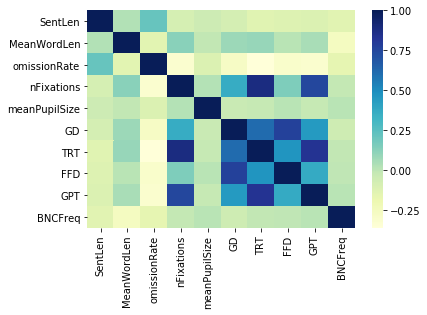

In [36]:
corr_mat(compute_allvals(sbjs_t3), heatmap=True, mask=False)

In [40]:
#print("p-value:", randomsample_paired_ttest(sentlens_t2, sentlens_t3))

p-value: 7.350782380298226e-06


In [43]:
#print("p-value:", randomsample_paired_ttest(wordlens_t2, wordlens_t3))

p-value: 0.014469258983305068


#### Mean fixations per word per subject

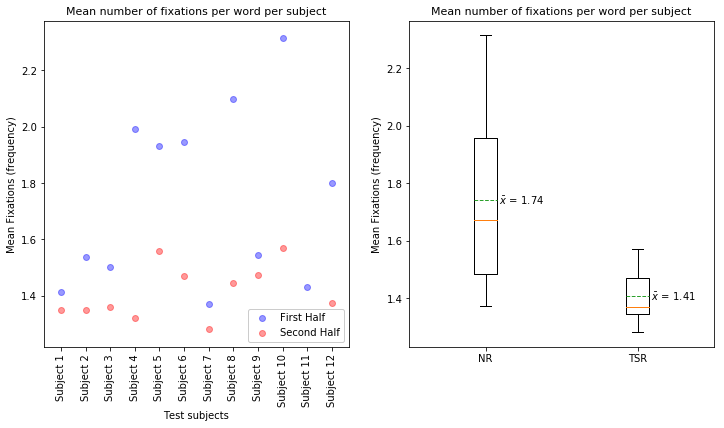

In [44]:
plot_fix(fixations_m_t2, fixations_m_t3)

#### Omission rate on sentence level

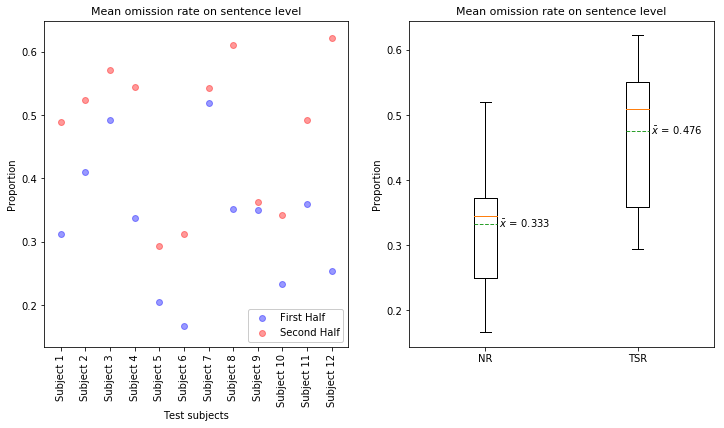

In [45]:
plot_omissions(omissions_m_t2, omissions_m_t3)

#### Mean GD per word per subject

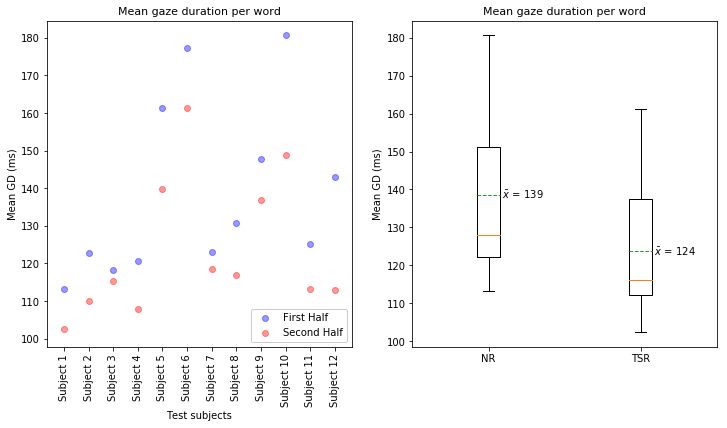

In [46]:
plot_gd(gd_m_t2, gd_m_t3)

#### Mean TRT per word per subject

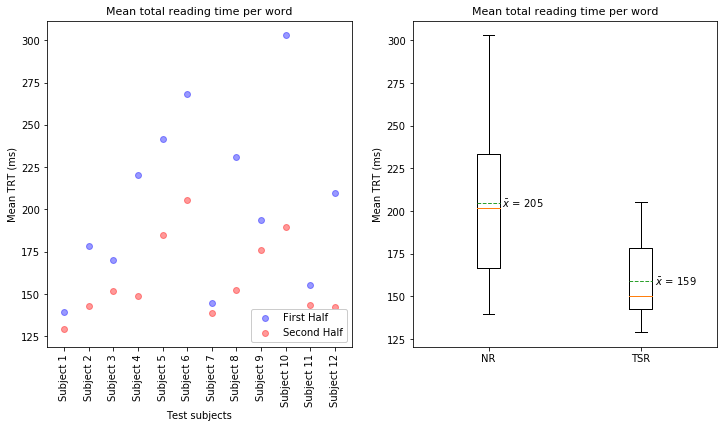

In [47]:
plot_trt(trt_m_t2, trt_m_t3)

#### Mean FFD per word per subject

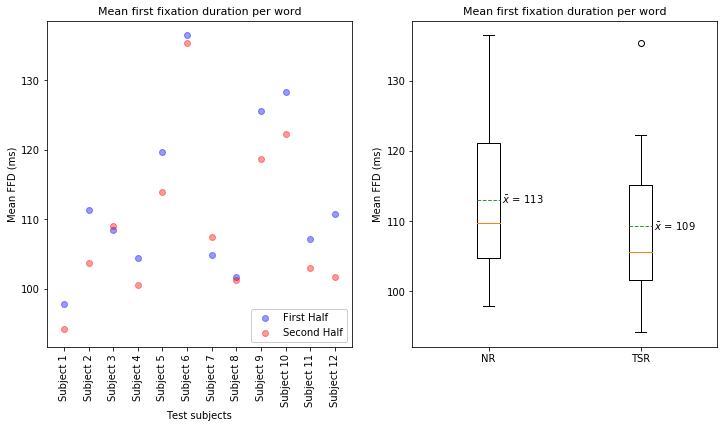

In [48]:
plot_ffd(ffd_m_t2, ffd_m_t3)